In [67]:
import pandas as pd

df = pd.read_csv("../datasets/preprocessed.csv")
df_funny = df.sort_values(by="funny_score")[::-1]
df_funny.head(5)

,image_id,caption,funny_score,image_url
1299162,bokete_100219,Listen to me. Listen to me. It's a relief that...,98148,https://d13n9ry8xcpemi.cloudfront.net/photo/od...
1368294,bokete_103390,Here comes the money-free users.,97638,https://d13n9ry8xcpemi.cloudfront.net/photo/od...
1424500,bokete_106922,When we turned in our assignments for the summ...,91873,https://d13n9ry8xcpemi.cloudfront.net/photo/od...
1299442,bokete_100225,It's... it's melon.,90692,https://d13n9ry8xcpemi.cloudfront.net/photo/od...
1217774,bokete_96112,I'm going to the second meeting!,88027,https://d13n9ry8xcpemi.cloudfront.net/photo/od...


In [ ]:
import torch
import json
from collections import defaultdict
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import random
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from torch.utils.data import ConcatDataset
from torch.nn.utils.rnn import pack_padded_sequence
import math
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
import copy
from transformers import ViTModel
import nltk
from nltk.tokenize import word_tokenize
import string
import matplotlib.ticker as ticker
import requests
from io import BytesIO


nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Borodum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Borodum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [69]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)


cpu


In [70]:
EPOCHS = 5
LEARNING_RATE = 3e-4
EMBED_DIM = 768
NUM_HEADS = 12
DEPTH = 6
MLP_DIM = 3072
DROP_RATE = 0.1

In [71]:
def clean_tokenize(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in string.punctuation]
    return tokens

In [72]:
def merge_vocabs(vocab1, vocab2):
    # Стартовые специальные токены
    merged_vocab = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
    idx = 4

    # Собираем все уникальные токены, кроме спецтокенов
    special_tokens = {'<pad>', '<start>', '<end>', '<unk>'}
    all_tokens = set(vocab1.keys()).union(set(vocab2.keys())) - special_tokens

    # Добавляем токены в итоговый словарь
    for token in sorted(all_tokens):
        merged_vocab[token] = idx
        idx += 1

    return merged_vocab

In [73]:
def create_vocab(annotations_path, min_freq = 5):
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)

    image_to_captions = defaultdict(list)
    for ann in annotations['annotations']:
        image_to_captions[ann['image_id']].append(ann['caption'])

    word_freq = {}
    for captions in image_to_captions.values():
        for caption in captions:
            tokens = clean_tokenize(caption.lower())
            for token in tokens:
                word_freq[token] = word_freq.get(token, 0)+1
    
    vocab = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
    idx = 4
    
    for token, freq in word_freq.items():
        if freq>= min_freq:
            vocab[token] = idx
            idx+=1

    return vocab

In [74]:
vocab_2014 = create_vocab("work/captions_train2014.json")
vocab_2017 = create_vocab("work/captions_train2017.json")
big_vocab = merge_vocabs(vocab_2014, vocab_2017)

In [75]:
class CrossAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout = 0.1):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads
        assert emb_size % num_heads == 0, "Embedding size must be divisible by number of heads."

        self.W_q = nn.Linear(emb_size, emb_size, bias = False)
        self.W_k = nn.Linear(emb_size, emb_size, bias = False)
        self.W_v = nn.Linear(emb_size, emb_size, bias = False)

        self.out = nn.Linear(emb_size, emb_size)

        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

    def forward(self, x, y, mask = None):
        batch_size, num_tokens_q, _ = x.shape
        _, num_tokens_k, _ = y.shape

        Q = self.W_q(x)  # (B, num_tokens_q, emb_size)
        K = self.W_k(y) # (B, num_tokens_k, emb_size)
        V = self.W_v(y) # (B, num_tokens_k, emb_size)

        Q = Q.view(batch_size, num_tokens_q, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, num_tokens_q, head_dim)
        K = K.view(batch_size, num_tokens_k, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, num_tokens_k, head_dim)
        V = V.view(batch_size, num_tokens_k, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, num_tokens_k, head_dim)

        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.head_dim) #(B, num_heads, num_tokens_q, num_tokens_k)

        if mask is not None:
            mask = mask.unsqueeze(-1).expand(-1, -1, num_tokens_k) #(B, num_tokens_q, num_tokens_k)
            mask = mask.unsqueeze(1).expand(-1, self.num_heads, -1, -1) #(B, num_heads, num_tokens_q, num_tokens_k)
            scores = scores.masked_fill(mask == False, float(-1e9))

        attn_weights = self.attn_dropout(torch.softmax(scores, dim=-1))
        attended = attn_weights @ V  # (B, num_heads, num_tokens_q, head_dim)

        concat = attended.transpose(1, 2).contiguous().view(batch_size, num_tokens_q, self.emb_size)  # (B, num_tokens_q, emb_size)
        return self.proj_dropout(self.out(concat))

In [76]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads, dropout):
        super().__init__()
        assert dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.num_heads = num_heads

        self.head_dim = dim // num_heads

        self.qkv = nn.Linear(dim, dim * 3, bias = False)
        self.out = nn.Linear(dim, dim, bias = False)

        self.scale = 1.0 / (self.head_dim ** 0.5)

        self.attn_dropout = nn.Dropout(dropout)

    def forward(self,  x, mask = None,  return_attn=False):
        B, num_patches, embed_dim = x.shape

        qkv = self.qkv(x) # (B, num_patches, 3*embed_dim)
        qkv = qkv.reshape(B, num_patches, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) #(3, B, num_heads, num_patches, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]  # each (B, num_heads, num_patches, head_dim)

                                        #How important it is for token i to pay attention to token j.
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale #[B, num_heads, N, N]

        if mask is not None:
            # mask: (B, N, N) 
            mask = mask.unsqueeze(1).expand(-1, self.num_heads, -1, -1) #[B, num_heads, N, N]
            attn_scores = attn_scores.masked_fill(mask == False, float(-1e9))

        attn_probs = attn_scores.softmax(dim=-1) #[B, num_heads, N, N]
        attn_probs = self.attn_dropout(attn_probs)
        attn_output = attn_probs @ v  # (B, num_heads, num_patches, head_dim)
        attn_output = attn_output.transpose(1, 2).reshape(B, num_patches, embed_dim)

        if return_attn:
          return self.out(attn_output), attn_probs
        else:
          return self.out(attn_output) #(B, num_patches, embed_dim)

In [77]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_dim, dropout):
        super().__init__()

        self.attn = MultiHeadAttention(dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.cross_attn = CrossAttention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

        self.norm3 = nn.LayerNorm(dim)

    def forward(self, x, y, self_mask=None, cross_mask=None):
        x = x + self.attn(self.norm1(x), mask = self_mask)
        x = x + self.cross_attn(self.norm2(x), y, mask = cross_mask)
        x = x + self.mlp(self.norm3(x))
        return x

In [78]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, embed_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [79]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, mlp_dim, num_layers, dropout=0.1, max_len=512):
        super().__init__()
        self.embed_tokens = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = PositionalEncoding(embed_dim, max_len)

        self.layers = nn.ModuleList([
            TransformerDecoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for i in range(num_layers)
        ])

        self.output_proj = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, encoder_output, self_mask=None, cross_mask=None):
        # x — индексы токенов (B, T)
        x = self.embed_tokens(x)  # (B, T, D)
        x = self.pos_embed(x)
        for layer in self.layers:
            x = layer(x, encoder_output, self_mask=self_mask, cross_mask=cross_mask)

        logits = self.output_proj(x)  # (B, T, vocab_size)
        return logits

In [80]:
class ImageCaptioningTransformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 embed_dim,
                 num_heads,
                 mlp_dim,
                 num_layers,
                 dropout):
        super().__init__()
        # Энкодер изображений (ViT)
        self.encoder = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)

        # Декодер текста
        self.decoder = TransformerDecoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            num_heads=num_heads,
            mlp_dim=mlp_dim,
            num_layers=num_layers,
            dropout=dropout,
            max_len=512
        )
        
        for param in self.encoder.parameters():
            param.requires_grad = False

    def _create_causal_mask(self, seq_len, device):
        mask = torch.tril(torch.ones((seq_len, seq_len), device=device))
        return mask.bool().unsqueeze(0) # [seq_len, seq_len]

    def forward(self, images, captions, self_mask=None, cross_mask=None):
        encoder_output = self.encoder(images).last_hidden_state  # (B, 1 + N, D)
        encoder_output_tokens = encoder_output[:, 1:, :] # (B, N, D)
        logits = self.decoder(captions, encoder_output_tokens, self_mask=self_mask, cross_mask=cross_mask)
        return logits

    def _beam_search(self, image, vocab, beam_width = 3, max_length=20):
        self.eval()

        start_token = vocab['<start>']
        end_token = vocab['<end>']
        device = image.device
        batch_size = 1

        beams = [{'tokens':[start_token], 'prob': 0.0}]
        with torch.no_grad():
          encoder_output = self.encoder(image).last_hidden_state  # (B, 1 + N, D)
          encoder_output_tokens = encoder_output[:, 1:, :] # (B, N, D)
          for i in range(max_length):
            all_cand = []
            for beam in beams:
              self_mask = self._create_causal_mask(i+1, device)
              tokens_tensor = torch.tensor(beam['tokens'], device=device).unsqueeze(0)
              logits = self.decoder(tokens_tensor, encoder_output_tokens, self_mask=self_mask)
              logit = logits[:, -1, :]  # последний токен
              log_probs = F.log_softmax(logit, dim=-1)
              top_log_probs, top_indices = log_probs.topk(beam_width)
              for prob, inx in zip(top_log_probs[0], top_indices[0]):
                all_cand.append({"tokens": beam['tokens']+[inx.item()], 'prob': beam['prob'] + prob.item()})
            all_cand = sorted(all_cand, key=lambda x: x['prob'], reverse=True)
            beams = all_cand[:beam_width]
            if all([beam['tokens'][-1] == end_token for beam in beams]):
              break

        best_beam = beams[0]
        output_tokens = best_beam['tokens']
        caption = []
        for token in output_tokens[1:]:
            if token == end_token:
                break
            caption.append(token)

        return torch.tensor(caption).unsqueeze(0)

    def _greedy(self, images, vocab, max_length=20):
      self.eval()

      start_token = vocab['<start>']
      end_token = vocab['<end>']
      device = images.device
      batch_size = images.shape[0]

      encoder_output = self.encoder(images).last_hidden_state  # (B, 1 + N, D)
      encoder_output_tokens = encoder_output[:, 1:, :] # (B, N, D)
      tokens = torch.full((batch_size, 1), start_token, dtype=torch.long, device=device)
      for i in range(max_length):
        self_mask = self._create_causal_mask(i+1, device)
        logits = self.decoder(tokens, encoder_output_tokens, self_mask=self_mask)
        logit = logits[:, -1, :]
        pred = logit.argmax(dim=-1)
        tokens = torch.cat([tokens, pred.unsqueeze(-1)], dim=-1)

        if (pred == end_token).all():
          break
 
      return tokens[:, 1:]

    def sample(self, images, vocab, strategy = 'greedy', beam_width = 3, max_length=20):
        if strategy == "beam":
            if images.shape[0] == 1:
                output = self._beam_search(images, vocab, beam_width, max_length)
            else:
                raise ValueError("Beam search supports only batch size 1. Got batch size {}".format(images.shape[0]))

        elif strategy == "greedy":
            output = self._greedy(images, vocab, max_length)

        else:
            raise ValueError(f"Unknown strategy '{strategy}'. Please choose either 'beam' or 'greedy'.")

        return output

In [81]:
model = ImageCaptioningTransformer(len(big_vocab), EMBED_DIM, NUM_HEADS, MLP_DIM, DEPTH, DROP_RATE)
checkpoint = torch.load("work/vit_epoch_5.pt", map_location=device, weights_only = False)
state = checkpoint["model_state_dict"]
state = {k: v for k, v in state.items() if "pooler" not in k}
model.load_state_dict(state)
model.to(device)
model.eval()

ImageCaptioningTransformer(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(

In [86]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def load_image_from_url(url):
    img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img_tensor


In [87]:
def tokens_to_text(tokens, inv_vocab):
    words = []
    for t in tokens:
        w = inv_vocab.get(int(t), "")
        if w in ["<start>", "<end>", "<pad>"]:
            continue
        words.append(w)
    return " ".join(words)


In [91]:
inv_vocab = {v: k for k, v in big_vocab.items()}


def get_caption(url):
    try:
        image = load_image_from_url(url)
    except Exception as e:
        return "url unaccessable"
    tokens = model.sample(image, big_vocab, strategy="greedy", max_length=20)
    caption = tokens_to_text(tokens[0].tolist(), inv_vocab)
    return caption


In [93]:
df_funny_1000 = df_funny[:10]
df_funny_1000["caption_gen"] = df_funny_1000["image_url"].apply(get_caption)
print(df_funny_1000.head())

              image_id                                            caption  \
1299162  bokete_100219  Listen to me. Listen to me. It's a relief that...   
1368294  bokete_103390                   Here comes the money-free users.   
1424500  bokete_106922  When we turned in our assignments for the summ...   
1299442  bokete_100225                                It's... it's melon.   
1217774   bokete_96112                   I'm going to the second meeting!   

         funny_score                                          image_url  \
1299162        98148  https://d13n9ry8xcpemi.cloudfront.net/photo/od...   
1368294        97638  https://d13n9ry8xcpemi.cloudfront.net/photo/od...   
1424500        91873  https://d13n9ry8xcpemi.cloudfront.net/photo/od...   
1299442        90692  https://d13n9ry8xcpemi.cloudfront.net/photo/od...   
1217774        88027  https://d13n9ry8xcpemi.cloudfront.net/photo/od...   

                                               caption_gen  
1299162            a man 

C:\Users\Borodum\AppData\Local\Temp\ipykernel_30892\1136052157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_funny_1000["caption_gen"] = df_funny_1000["image_url"].apply(get_caption)


Image 6 Caption: a man is sitting on a chair talking on a cell phone
URL: https://d13n9ry8xcpemi.cloudfront.net/photo/odai/400/68642ab88e6f2d2ef47d14c3800f0790_400.jpg

Image 7 Caption: a man with a beard and a beard on a cell phone
URL: https://d13n9ry8xcpemi.cloudfront.net/photo/odai/400/c964d8966f7f606e8301bb39ca178c50_400.jpg

Image 8 Caption: a man in a suit and tie is looking at a camera
URL: https://d13n9ry8xcpemi.cloudfront.net/photo/odai/400/a6836d0a25d3858a993da9840e898880_400.jpg

Image 9 Caption: a man is holding a soccer ball in his hand
URL: https://d13n9ry8xcpemi.cloudfront.net/photo/odai/400/05861b8e4b33ada4b3818d4ed6589984_400.jpg

Image 10 Caption: a cat sitting on top of a white and white plate
URL: https://d13n9ry8xcpemi.cloudfront.net/photo/odai/400/ba141884486b431a3681def01d546174_400.jpg



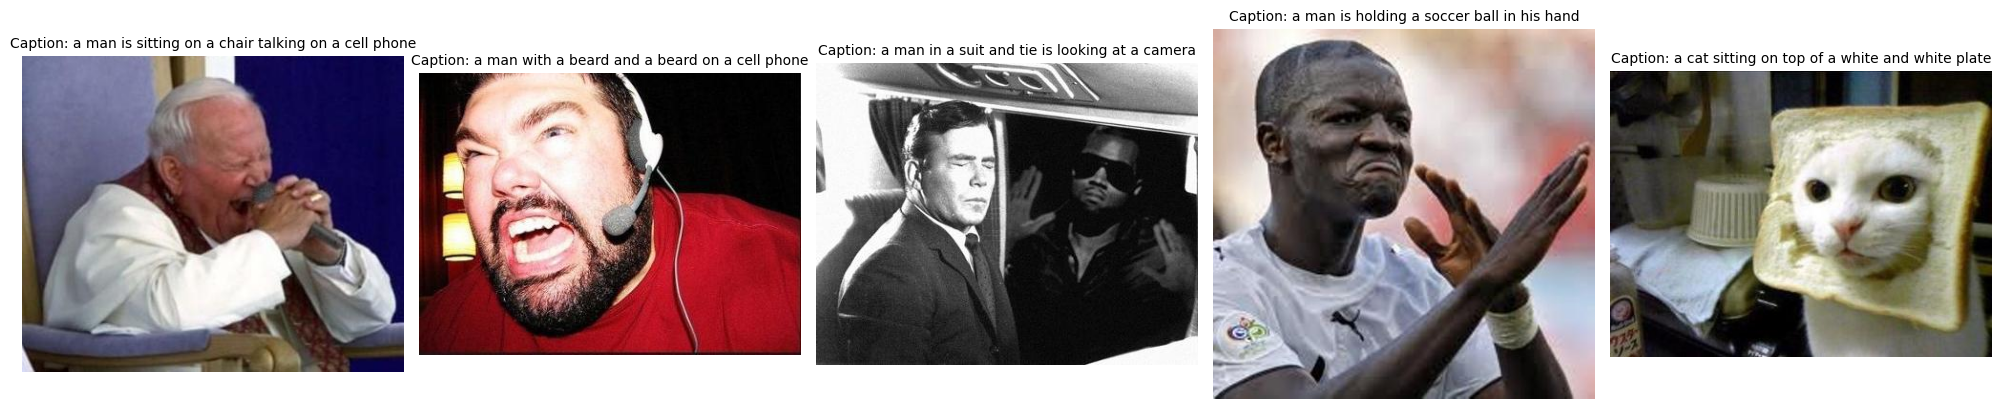

In [102]:
from PIL import Image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5, 10):
    try:
        img_url = df_funny_1000.iloc[i]['image_url']
        caption = df_funny_1000.iloc[i]['caption_gen']
        
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content))
        
        axes[i-5].imshow(img)
        axes[i-5].set_title(f"Caption: {caption}", fontsize=10)
        axes[i-5].axis('off')
        
        print(f"Image {i+1} Caption: {caption}")
        print(f"URL: {img_url}\n")
        
    except Exception as e:
        print(f"Error loading image {i+1}: {e}")
        axes[i].axis('off')
        axes[i].set_title(f"Error loading image", fontsize=10)

plt.tight_layout()
plt.show()